<a href="https://colab.research.google.com/github/AmurdAmzer/SAKT-Paper_Implementation/blob/main/SAKTPaperImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1: Uploading data via Colab's File Browser

In [4]:
import os
print("Files in current directory:")
for file in os.listdir():
  if file.endswith(".csv"):
    print(f" - {file}")

Files in current directory:
 - skill_builder_data_corrected_collapsed.csv


#Cell 2: Imports and File upload

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file (Remember to use the actual file name)
# encoding='ISO-8859-1' handles special characters in the data
# low_memory=False prevents dtype warnings for mixed types

# I choose to call my loaded data df, df can mean DataFrame, df is just a variable name, I can choose to name my uploaded data anything.
df = pd.read_csv('skill_builder_data_corrected_collapsed.csv', encoding='ISO-8859-1', low_memory=False)

# Show basic information about the dataset
print(f"Dataset shape: {df.shape}") # (rows, columns)
print(f"\nColumn names: {list(df.columns)}") # all column names
print(f"\nFirst 5 rows: {df.head()}") # preview first 5 rows


Dataset shape: (346860, 31)

Column names: ['Unnamed: 0', 'order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id', 'original', 'correct', 'attempt_count', 'ms_first_response', 'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id', 'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name', 'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time', 'template_id', 'answer_id', 'answer_text', 'first_action', 'bottom_hint', 'opportunity', 'opportunity_original']

First 5 rows:    Unnamed: 0  order_id  assignment_id  user_id  assistment_id  problem_id  \
0           1  33022537         277618    64525          33139       51424   
1           2  33022709         277618    64525          33150       51435   
2           3  35450204         220674    70363          33159       51444   
3           4  35450295         220674    70363          33110       51395   
4           5  35450311         220674    70363          33196       51481   

   original 

# Cell3: Key Statistics - Understanding the dataset size and scope

In [9]:
# Cell 3: Key Statistics - Understanding the dataset size and scope

print("===DATASET OVERVIEW===")

# Count total number of student interactions = number of rows
print(f"Toatal interactions: {len(df)}")

# Count unique students - each student has a unique user_id
print(f"Unique students: {df['user_id'].nunique()}") # df['user_id] = access the user id column. nunique = count how many unique values are in that column

# Count unique problems - individual questions students attempted
print(f"Unique problems: {df['problem_id'].nunique()}")

# Count unique skills - knowledge concepts being tested. this is crucial because I will create embeddings for each skill
print(f"Unique problems: {df['skill_id'].nunique()}")

# Calculate overall performance - percentage of correct answers
print(f"\nCorrect rate: {df['correct'].mean():.2%}")  # .2% means format the number as percentage with two decimal places, so for eg. 0.825641 becomes 82.56%

# Check data completeness for skill_id (Critical for SAKT)
# NB. SAKT needs skill_id to work - rows without the skill_id must be removed
print(f"Rows with skill_id: {df['skill_id'].notna().sum()}")
print(f"Missing skill_id: {df['skill_id'].isna().sum()} ({df['skill_id'].isna().mean():.1%})")


=== DATASET OVERVIEW ===
Total interactions: 346860
Unique students: 4217
Unique problems: 26688
Unique skills: 149

Correct rate: 64.53%
Rows with skill_id: 283105
Missing skill_id: 63755 (18.4%)


# CELL 4: Examine One Student's Learning Journey
# This helps us understand the sequential nature of the data

In [10]:
# CELL 4: Examine One Student's Learning Journey
# This helps us understand the sequential nature of the data

# Find students sorted by number of attempts (most active students)
student_activity = df['user_id'].value_counts()

# Pick the 11th most active student (avoiding outliers)
student_id = student_activity.index[10]

# Get all data for this student, sorted by time
# order_id represents the sequence of attempts
student_data = df[df['user_id'] == student_id].sort_values('order_id')

# Display student summary
print(f"Student {student_id} attempted {len(student_data)} problems")
print(f"Skills attempted: {student_data['skill_id'].nunique()}")
print(f"Correct rate: {student_data['correct'].mean():.2%}")

# Show their first 10 attempts to see the sequential pattern
print("\nFirst 10 attempts:")
print(student_data[['order_id', 'skill_id', 'correct', 'ms_first_response']].head(10))

Student 78980 attempted 1112 problems
Skills attempted: 94
Correct rate: 58.45%

First 10 attempts:
        order_id skill_id  correct  ms_first_response
110037  20882484       58        1              75090
184857  20882593      277        0               9044
184858  20882618      277        1              14863
184859  20882633      277        1              14619
184860  20882650      277        1              15088
184861  20882693      277        1              40358
184862  20960207      277        1              17053
202327  20960246      279        1              34975
202328  20960333      279        1               8606
202329  21076113      279        0              17704


# CELL 5: Visualize Key Patterns to Understand Our Data Better

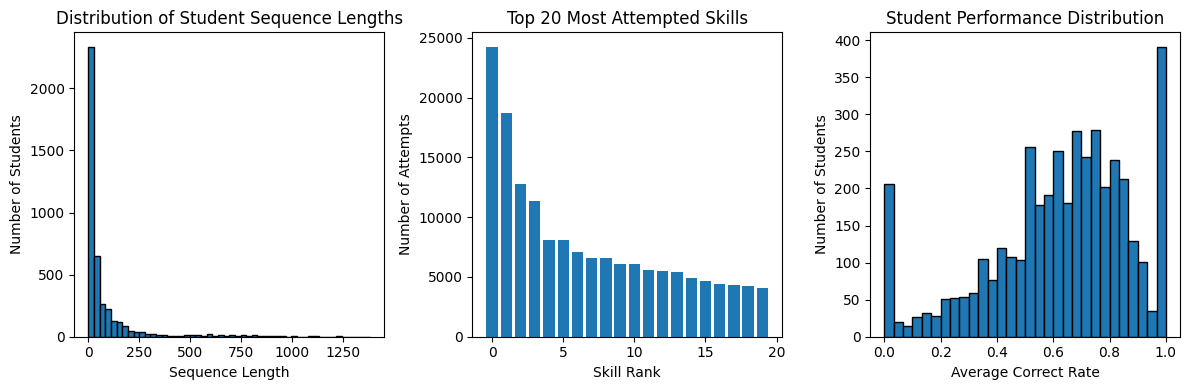


Sequence Length Statistics:
Min: 1
Max: 1383
Mean: 82.3
Median: 23.0


In [11]:
# CELL 5: Visualize Key Patterns to Understand Our Data Better

# Calculate sequence length for each student (how many problems each student attempted)
seq_lengths = df.groupby('user_id').size()

# Create figure with 3 subplots side by side
plt.figure(figsize=(12, 4))

# SUBPLOT 1: Distribution of Student Sequence Lengths
plt.subplot(1, 3, 1)
# Create histogram with 50 bins and black edges for clarity
plt.hist(seq_lengths, bins=50, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Students')
plt.title('Distribution of Student Sequence Lengths')
# This shows us if we have enough data per student for SAKT

# SUBPLOT 2: Most Attempted Skills
plt.subplot(1, 3, 2)
# Count attempts per skill and get top 20
skill_attempts = df['skill_id'].value_counts().head(20)
# Create bar plot with rank on x-axis
plt.bar(range(len(skill_attempts)), skill_attempts.values)
plt.xlabel('Skill Rank')
plt.ylabel('Number of Attempts')
plt.title('Top 20 Most Attempted Skills')
# This shows if some skills dominate the dataset

# SUBPLOT 3: Student Performance Distribution
plt.subplot(1, 3, 3)
# Calculate average correct rate for each student
student_performance = df.groupby('user_id')['correct'].mean()
# Create histogram of performance
plt.hist(student_performance, bins=30, edgecolor='black')
plt.xlabel('Average Correct Rate')
plt.ylabel('Number of Students')
plt.title('Student Performance Distribution')
# This shows the overall difficulty level

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

# Print summary statistics for sequence lengths
print(f"\nSequence Length Statistics:")
print(f"Min: {seq_lengths.min()}")
print(f"Max: {seq_lengths.max()}")
print(f"Mean: {seq_lengths.mean():.1f}")
print(f"Median: {seq_lengths.median():.1f}")

# CELL 6: Data Quality Check - Critical for Reliable Model Training

In [12]:
# CELL 6: Data Quality Check - Critical for Reliable Model Training

print("Data Quality Report:")
print("-" * 40)

# Check 1: Duplicate rows (same data appearing multiple times)
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    print("  ⚠️  Need to remove duplicates!")

# Check 2: Students with very few attempts
# SAKT needs sufficient history to learn patterns
too_few = (seq_lengths < 5).sum()
print(f"Students with <5 attempts: {too_few} ({too_few/len(seq_lengths)*100:.1f}%)")

# Check 3: Students with too many attempts (potential outliers)
too_many = (seq_lengths > 500).sum()
print(f"Students with >500 attempts: {too_many}")

# Check 4: Temporal ordering validation
# Sort by user and order_id to check sequence integrity
df_sorted = df.sort_values(['user_id', 'order_id'])
# For each user, check if order_id always increases
is_ordered = df_sorted.groupby('user_id')['order_id'].apply(
    lambda x: (x.diff().dropna() > 0).all()  # diff() calculates difference between consecutive values
).all()
print(f"All sequences properly ordered: {is_ordered}")

# Check 5: Original vs scaffolding problems
# Original = main problem, scaffolding = hints/sub-problems
original_count = (df['original'] == 1).sum()
scaffold_count = (df['original'] == 0).sum()
print(f"\nOriginal problems: {original_count} ({original_count/len(df)*100:.1f}%)")
print(f"Scaffolding problems: {scaffold_count} ({scaffold_count/len(df)*100:.1f}%)")
print("  💡 SAKT paper uses only original problems")

# Check 6: Answer distribution
print(f"\nAnswer distribution:")
print(f"Correct: {(df['correct'] == 1).sum()} ({df['correct'].mean()*100:.1f}%)")
print(f"Incorrect: {(df['correct'] == 0).sum()} ({(1-df['correct'].mean())*100:.1f}%)")

# Check 7: Critical missing data for SAKT
print(f"\nMissing data analysis:")
print(f"Missing skill_id: {df['skill_id'].isna().sum()} rows ({df['skill_id'].isna().mean()*100:.1f}%)")
print(f"Missing user_id: {df['user_id'].isna().sum()} rows")
print(f"Missing correct: {df['correct'].isna().sum()} rows")
print("  ⚠️  SAKT requires skill_id, user_id, and correct to be present")

Data Quality Report:
----------------------------------------
Duplicate rows: 0
Students with <5 attempts: 473 (11.2%)
Students with >500 attempts: 181
All sequences properly ordered: True

Original problems: 275458 (79.4%)
Scaffolding problems: 71402 (20.6%)
  💡 SAKT paper uses only original problems

Answer distribution:
Correct: 223818 (64.5%)
Incorrect: 123042 (35.5%)

Missing data analysis:
Missing skill_id: 63755 rows (18.4%)
Missing user_id: 0 rows
Missing correct: 0 rows
  ⚠️  SAKT requires skill_id, user_id, and correct to be present
